In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv').values.ravel()
y_test = pd.read_csv('data/y_test.csv').values.ravel()

In [12]:
# We apply smote on training set to avoid data leakage.
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#We check if the number of rows as been changed
print(f"Original dataset shape: {len(y_train)} rows (Imbalanced)")
print(f"Resampled dataset shape: {len(y_train_smote)} rows (Balanced 50/50)")

# We use the same pipeline as before but as we used smote we dont have to used balanced
model_smote = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
model_smote.fit(X_train_smote, y_train_smote)

# Evaluation
y_pred_smote = model_smote.predict(X_test)

print("\nResults: SMOTE + Logistic Regression")
print(classification_report(y_test, y_pred_smote, digits=4))

Original dataset shape: 1037340 rows (Imbalanced)
Resampled dataset shape: 2062670 rows (Balanced 50/50)

Results: SMOTE + Logistic Regression
              precision    recall  f1-score   support

           0     0.9983    0.9832    0.9907    257834
           1     0.1979    0.7109    0.3096      1501

    accuracy                         0.9816    259335
   macro avg     0.5981    0.8470    0.6501    259335
weighted avg     0.9937    0.9816    0.9868    259335



Instead of simply adjusting weights, we used SMOTE to generate new fraud examples in the training set, achieving a perfect class balance.
The precision improved (19.79%), we got improvement compared to the Balanced model in the previous notebook (3.5%).
But, the recall decreased (71.09%), we have a trade-off. While the model is more precise, the recall dropped slightly compared to the weighted model (76%) of the previous notebook.

0:	learn: 0.5371976	total: 227ms	remaining: 1m 53s
100:	learn: 0.0526806	total: 16.4s	remaining: 1m 4s
200:	learn: 0.0343517	total: 32.4s	remaining: 48.1s
300:	learn: 0.0252005	total: 48.1s	remaining: 31.8s
400:	learn: 0.0200529	total: 1m 4s	remaining: 15.9s
499:	learn: 0.0167074	total: 1m 20s	remaining: 0us

Results: CatBoost - Balanced
              precision    recall  f1-score   support

           0     0.9998    0.9919    0.9958    257834
           1     0.4103    0.9647    0.5757      1501

    accuracy                         0.9918    259335
   macro avg     0.7051    0.9783    0.7858    259335
weighted avg     0.9964    0.9918    0.9934    259335



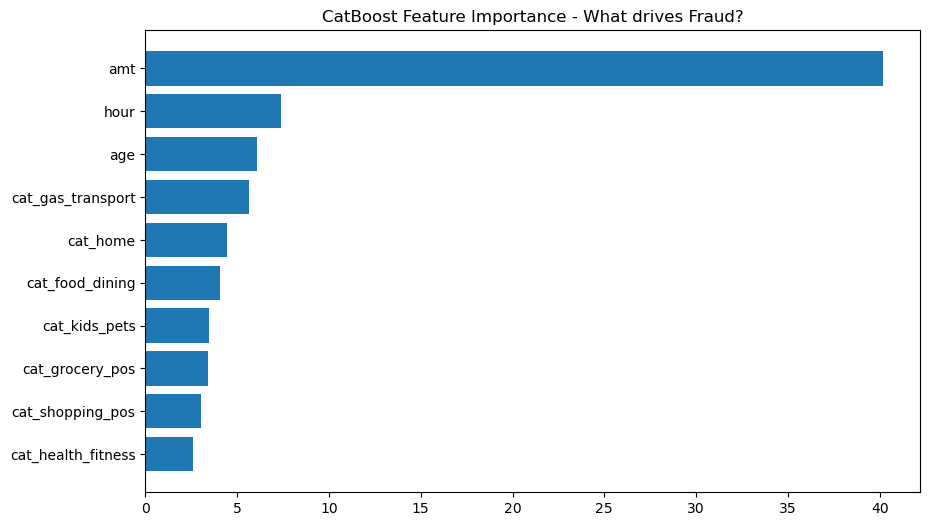

In [13]:
# We configure CatBoost with balanced class weights to handle the huge imbalance we have
cat_model = CatBoostClassifier(
    iterations=500,           
    learning_rate=0.1,
    depth=6,
    auto_class_weights='Balanced', 
    verbose=100,              
    random_state=42
)

cat_model.fit(X_train, y_train)

# Predictions
y_pred_cat = cat_model.predict(X_test)

print("\nResults: CatBoost - Balanced")
print(classification_report(y_test, y_pred_cat, digits=4))

# We take the best features that catboostmodel decided
feature_importance = cat_model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)[-10:] 

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('CatBoost Feature Importance - What drives Fraud?')
plt.show()

We use a new approach, Catboost, and see that it ouperformed all previous approaches.
The recall has increased to 96.47%, meaning it detects almost every fraud case. Also, the precision as also improved a lot from 19.79% to 41.03%, that is really important because it means the number of fake detection has been divided by 2.

The chart we decided to show is really interesting for interpretation, it tells which feature is a decision maker for the model and we see that amt, the amount of the transaction is the most determining feature for the model. The other most important features are the time of the day of the transaction (hour), the age of the person doing the transaction (age) and the sector of the transaction (cat_gas_transport, cat_home, ...)

So, with this gradient boosting, we successfully captured the non-linear relationships that we previously missed with other models.

In [14]:
# We define the base model
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 2. Define the parameter grid
param_grid = {
    'n_estimators': [50, 100],       
    'max_depth': [10, 15],           
    'min_samples_leaf': [2, 5]       
}
# We launch the gridsearch and focus on optimising the f1-score
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# we get the best model
best_rf = grid_search.best_estimator_

print(f"\nBest Parameters Found: {grid_search.best_params_}")

# we evaluate the optimized model
y_pred_rf = best_rf.predict(X_test)

print("\nResults: Optimized Random Forest")
print(classification_report(y_test, y_pred_rf, digits=4))

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best Parameters Found: {'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 50}

Results: Optimized Random Forest
              precision    recall  f1-score   support

           0     0.9994    0.9949    0.9972    257834
           1     0.5092    0.9021    0.6510      1501

    accuracy                         0.9944    259335
   macro avg     0.7543    0.9485    0.8241    259335
weighted avg     0.9966    0.9944    0.9952    259335



The Optimized Random Forest achieved the highest F1-Score 0.6510 of all models so far. The optimization process successfully found the best parameters (max_depth: 15, n_estimators: 50) to balance the model.

We can compare those results whith CatBoost, here the precision has increased from 41.03% to 50.92% here which means that we lost 10% of fraud detection that were not real fraud. But, the recall dropped a bit passing from 96.47% to 90.21% so we loose 6% of fraud detection in total.

While CatBoost is the best at finding all frauds, Random Forest is the most reliable. This diversity of the scores between the two previous model is perfect to be combined in a final Voting Classifier.

In [15]:
# we need to re-instantiate the Log Reg without the pipeline for the compatibility with VotingClassifier
lr_vote = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_vote),
        ('cat', cat_model),
        ('rf', best_rf)
    ],
    voting='soft', # we put soft to get average of probabilities and to get a better recall
    weights=[1, 2, 2] # We give more weight to the best models 
)

voting_clf.fit(X_train, y_train)

y_pred_vote = voting_clf.predict(X_test)

print("\nResults: Voting Classifier (Ensemble)")
print(classification_report(y_test, y_pred_vote, digits=4))

0:	learn: 0.5371976	total: 189ms	remaining: 1m 34s
100:	learn: 0.0526806	total: 18.1s	remaining: 1m 11s
200:	learn: 0.0343517	total: 36.1s	remaining: 53.7s
300:	learn: 0.0252005	total: 52.8s	remaining: 34.9s
400:	learn: 0.0200529	total: 1m 9s	remaining: 17.2s
499:	learn: 0.0167074	total: 1m 25s	remaining: 0us

Results: Voting Classifier (Ensemble)
              precision    recall  f1-score   support

           0     0.9997    0.9936    0.9967    257834
           1     0.4658    0.9560    0.6264      1501

    accuracy                         0.9934    259335
   macro avg     0.7328    0.9748    0.8115    259335
weighted avg     0.9967    0.9934    0.9945    259335




The Voting Classifier combines the strengths of our three models and shows a good sinergy.

The recall is really good, 95.6% and really near of our best recall from CatBoost (96.5%). The precision is also good because we are at 46.58%, way better than CatBoost (41.03%) and a bit under Random Forest (50.92%)

Compared to CatBoost, we gained +5.5% Precision (fewer false alarms) for a tiny cost of -0.9% Recall.
Compared to Random Forest: We gained +5.4% Recall (catching more fraud) for a manageable drop in Precision.

The Voting Classifier provides the most robust solution. It offers the high detection rate needed for security while keeping operational costs (false positives). It stabilizes the predictions.

In [17]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
# We regroup our past predictions in a dictionnary
models_preds = {
    "1. SMOTE + RegLog": y_pred_smote,
    "2. CatBoost (Balanced)": y_pred_cat,
    "3. Optimized Random Forest": y_pred_rf,
    "4. Voting Classifier (Ensemble)": y_pred_vote
}

results = []

for model_name, preds in models_preds.items():
    results.append({
        "Model": model_name,
        "Recall": recall_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "F1-Score": f1_score(y_test, preds),  
        "Accuracy": accuracy_score(y_test, preds)
    })


# We sort the models by F1-score
results_df = pd.DataFrame(results).set_index("Model").sort_values(by="F1-Score", ascending=False)

# Affichage du tableau
print(results_df)

with open('data/best_model.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)


                                   Recall  Precision  F1-Score  Accuracy
Model                                                                   
3. Optimized Random Forest       0.902065   0.509214  0.650962  0.994401
4. Voting Classifier (Ensemble)  0.956029   0.465758  0.626364  0.993399
2. CatBoost (Balanced)           0.964690   0.410315  0.575746  0.991771
1. SMOTE + RegLog                0.710859   0.197886  0.309589  0.981649


We see here that the best optimized model is the Random Forest one with the best F1-score among every models. He got the also the highest precision but his recall is only the 3rd best.
The CatBoost model is the best to detect frauds with the highest recall but the precision is only the 3rd best which generates a lot of false alarms.
The Voting Classifier combines the good recall of the CatBoost model with the good precision of Random Forest offering the most robust solution.
We choose to select the Voting Classifier as our final model of this part and save it for next part.